Do high-coefficient terms commute more often than low-coefficient terms in a Hydrogen chain?

In [12]:
import argparse
import json
from math import sqrt, ceil
import numpy as np
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from openfermionpyscf import run_pyscf
import qiskit
from qiskit.circuit.library import PauliEvolutionGate, phase_estimation
from qiskit.synthesis import LieTrotter
from qiskit import transpile
import quimb.tensor as qtn
from tensor_network_common import pauli_sum_to_mpo
from convert import cirq_pauli_sum_to_qiskit_pauli_op
from qpe_trotter import (
    group_single_strings,
    trotter_perturbation,
    bits_for_epsilon,
    get_gate_counts
)

In [3]:
max_mpo_bond = 300

In [16]:
l = 6
bond_length = 1.0 
natoms = l
geometry = [("H", (0, 0, i * bond_length)) for i in range(natoms)]
molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)  # To get ground state energy for comparison etc., also can use DMRG
fermion_hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(fermion_hamiltonian)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")
ham_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(ham_cirq)
ham_mpo = pauli_sum_to_mpo(ham_cirq, qs, max_mpo_bond)

Hamiltonian has 919 terms.
Hamiltonian has 12 qubits.


In [17]:
def pstring_is_diagonal(pstring: cirq.PauliString) -> bool:
    """Test if a Pauli string is diagonal."""

    is_diagonal = True
    for q, p in pstring.items():
        if p == cirq.X or p == cirq.Y:
            is_diagonal = False
            break
    return is_diagonal

In [18]:
coefficients = []
is_diag = []
for ps in ham_cirq:
    coefficients.append(abs(ps.coefficient))
    is_diag.append(pstring_is_diagonal(ps))
    

(array([840.,  32.,  37.,   3.,   2.,   2.,   0.,   1.,   0.,   2.]),
 array([1.23106410e-04, 4.24818557e-02, 8.48406050e-02, 1.27199354e-01,
        1.69558104e-01, 2.11916853e-01, 2.54275602e-01, 2.96634351e-01,
        3.38993101e-01, 3.81351850e-01, 4.23710599e-01]),
 <BarContainer object of 10 artists>)

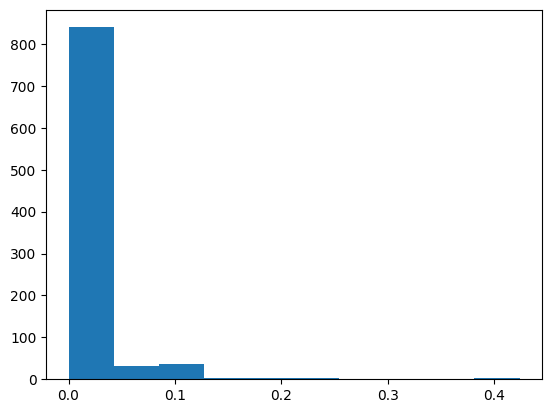

In [19]:
fig, ax = plt.subplots()
ax.hist(coefficients)

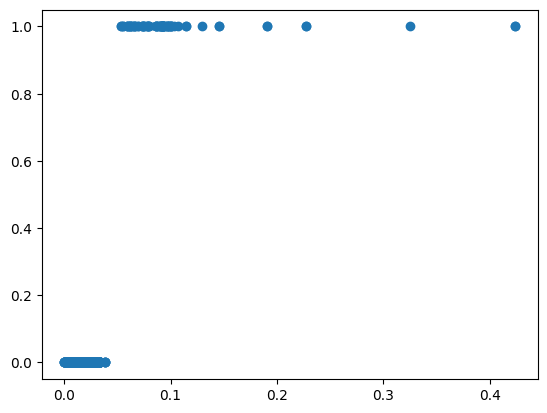

In [20]:
fig2, ax2 = plt.subplots()
ax2.scatter(coefficients, is_diag)